In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import torch.nn as nn

In [2]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [3]:
class MLP(nn.Module):

    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP,self).__init__() ## access methods and properties of a parent (or superclass)
        self.network_head = nn.Sequential(nn.Linear(data_dim,hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim,hidden_dim),
                                          nn.ReLU())
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim,hidden_dim),
                                          nn.ReLU(),
                                          nn.Linear(hidden_dim,data_dim*2)) for t in range(N)]) ## x2 bc mu and sigma
    def forward(self, x , t):
        h = self.network_head(x) # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h) # [batch_size, datasetx2]
        mu, h = torch.chunk(tmp, 2, dim=1) # split into mu and std
        var = torch.exp(h)
        std = torch.sqrt(var)

        return mu, std

In [18]:
model = torch.load("model_paper1")
t=5
x = torch.rand((64,2))
mu, std = model(x,t)

print(mu.shape)

torch.Size([64, 2])


In [4]:
class DiffusionModel():
    
    def __init__(self,  T, model: nn.Module, dim=2):
        
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)

        self.T = T
        self.model = model
        self.dim = dim
        
    def forward_process(self, x0, t): 
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        
        t = t -1 # Because we start indexing at 0
        
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        xt =  mu + epsilon * std # data ~ N(mu, std)

        m1 = torch.sqrt(self.alphas_bar[t-1])*self.betas[t]/(1-self.alphas_bar[t])
        m2 = torch.sqrt(self.alphas_bar[t])*(1-self.alphas_bar[t-1])/(1-self.alphas_bar[t])
        mu_q = m1*x0 + m2*xt
        std_q = torch.sqrt((1-self.alphas_bar[t-1])*self.betas[t]/(1-self.alphas_bar[t]))
        
        return mu_q, std_q, xt 
    
    def reverse_process(self, xt, t):
        """
        :param t: Number of diffusion steps
        """
        
        assert t > 0, 't should be greater than 0'
        assert t <= self.T
        
        t = t - 1 # Because we start indexing at 0

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)

        return mu, std, mu + epsilon * std
    
    def sample(self, batch_size):
        noise = torch.randn((batch_size,self.dim))
        x = noise
        samples = [x]
        for t in range(self.T, 0, -1):
            
            if not (t == 1):
                _, _, x = self.reverse_process(x, t)
            
            samples.append(x)
            
        return samples[::-1]
    


    def get_loss(self, x0):
        ## all wee need is mu_p,q and sigma_p,q
        t = torch.randint(2,40+1,(1,)) ## sample random step
        mu_q, sigma_q, xt = self.forward_process(x0,t)
        mu_p, sigma_p, xt_minus1 = self.reverse_process(xt.float(), t)
        
        #print(sigma_q)
        KL = torch.log(sigma_q) - torch.log(sigma_p) + (sigma_p**2 + (mu_p-mu_q)**2)/(2*sigma_q**2) - 0.5
        K = -KL.mean()
        loss = -K

        return loss

In [5]:
x0 = sample_batch(256)
mlp_model = torch.load("model_paper1")
model = DiffusionModel(40, mlp_model)
model.get_loss(x0)

FileNotFoundError: [Errno 2] No such file or directory: 'model_paper1'

In [75]:
x0 = sample_batch(3_000)
model = DiffusionModel(40)
xT = model.forward_process(x0, 20)

TypeError: __init__() missing 1 required positional argument: 'model'

In [6]:
def inf_train_gen(batch_size: int = 200, device: str = "cpu"):
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = torch.rand(batch_size, device=device) - torch.randint(high=2, size=(batch_size, ), device=device) * 2
    x2 = x2_ + (torch.floor(x1) % 2)

    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45
    
    return data.float()

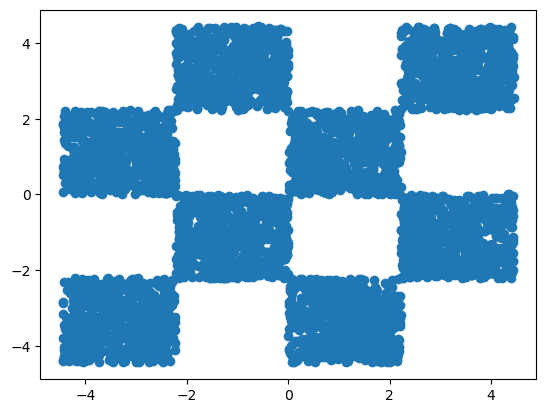

In [83]:
dat = inf_train_gen(5000)
plt.scatter(dat[:,0],dat[:,1])

tensor(-0.0045)
tensor(0.9952)


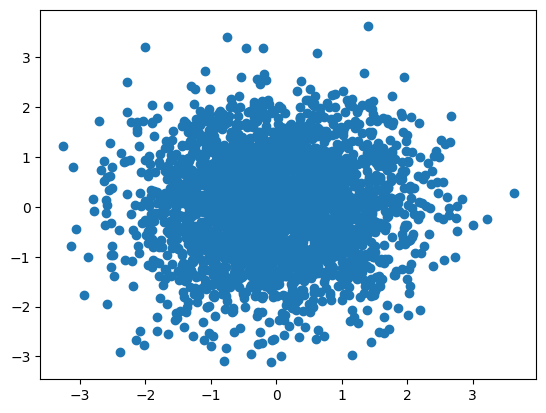

In [17]:
x0 = inf_train_gen(3_000)
mlp_model = MLP()
model = DiffusionModel(80,mlp_model)
_, _, xT = model.forward_process(x0, 80)
plt.scatter(xT[:,0],xT[:,1])
print(xT.mean())
print(xT.std())

In [11]:
xT

(tensor([[-0.0568, -0.0067],
         [-0.1076, -0.1276],
         [ 0.0326,  0.0560],
         ...,
         [-0.2324, -0.0468],
         [-0.1346,  0.0602],
         [-0.0803, -0.1349]]),
 tensor(0.5470),
 tensor([[-0.1276,  0.6550],
         [-0.8921, -1.0879],
         [ 0.1573, -0.0997],
         ...,
         [-1.6676, -1.1857],
         [-1.2826, -0.2917],
         [-1.1630, -0.7630]]))

In [5]:
print(xT.mean(0))
print(xT.std(0))

tensor([ 0.0143, -0.2059], dtype=torch.float64)
tensor([0.6908, 0.6568], dtype=torch.float64)


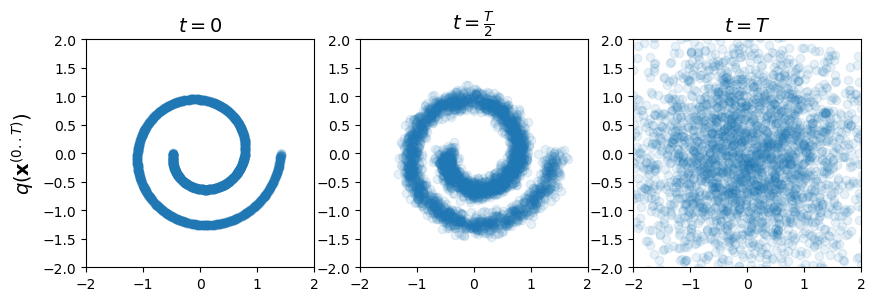

In [6]:
fontsize = 14
fig = plt.figure(figsize=(10, 3))

data = [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)]
for i in range(3):
    
    plt.subplot(1, 3, 1+i)
    plt.scatter(data[i][:, 0].data.numpy(), data[i][:, 1].data.numpy(), alpha=0.1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')
    
    if i == 0: plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
    if i == 0: plt.title(r'$t=0$', fontsize=fontsize)
    if i == 1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
    if i == 2: plt.title(r'$t=T$', fontsize=fontsize)
plt.savefig('forward_process.png', bbox_inches='tight')

In [46]:
x0 = sample_batch(3_000)
mlp_model = torch.load("model_paper1")
model = DiffusionModel(40, mlp_model)
xT = model.forward_process(x0, 20)

In [47]:
samples = model.sample(1000)

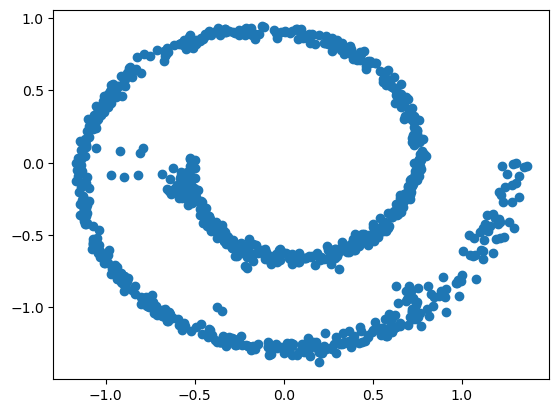

In [49]:
plt.scatter(samples[0][:,0].data.numpy(),samples[0][:,1].data.numpy())

In [38]:
len(samples)

1

In [44]:
for t in range(40, 0, -1):
    print(t)

40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
